In [1]:
# Load our libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# Use a nicer style for plots
plt.style.use("seaborn-v0_8-muted")

In [104]:
target_data = pd.read_csv("/Users/rubenstark/Documents/GitHub/Its-Wekk/4 - Data/Final_Data/Cleaned/10Targcleaned.csv")

In [98]:
print(target_data.head(10))

                  Datum/Zeit       timestamp_text  PM10 (Stundenmittelwerte)  \
0  2021-11-30 23:00:00+00:00  2021-12-01 00:00:00                      7.456   
1  2021-12-01 00:00:00+00:00  2021-12-01 01:00:00                      4.832   
2  2021-12-01 01:00:00+00:00  2021-12-01 02:00:00                      4.682   
3  2021-12-01 02:00:00+00:00  2021-12-01 03:00:00                      5.035   
4  2021-12-01 03:00:00+00:00  2021-12-01 04:00:00                      5.102   
5  2021-12-01 04:00:00+00:00  2021-12-01 05:00:00                      4.612   
6  2021-12-01 05:00:00+00:00  2021-12-01 06:00:00                      4.498   
7  2021-12-01 06:00:00+00:00  2021-12-01 07:00:00                      5.400   
8  2021-12-01 07:00:00+00:00  2021-12-01 08:00:00                      5.397   
9  2021-12-01 08:00:00+00:00  2021-12-01 09:00:00                      6.484   

   PM2.5 (Stundenmittelwerte)  O3 (Stundenmittelwerte)  \
0                       7.023                   38.615   
1  

In [105]:

target_data2 = target_data[['Datum/Zeit', 'PM10 (Stundenmittelwerte)']]

# Dataset filtern, sodass es nur Einträge ab dem 28.12.2021 enthält
filtered_data = target_data2[target_data2['Datum/Zeit'] >= '2021-12-28'].copy()

filtered_data.rename(columns={'Datum/Zeit': 'Datum'}, inplace=True)

# Überprüfen, ob das gefilterte Dataset korrekt ist
print(filtered_data.head())

# Spaltennamen ausgeben
print(filtered_data.columns)

                         Datum  PM10 (Stundenmittelwerte)
649  2021-12-28 00:00:00+00:00                     10.451
650  2021-12-28 01:00:00+00:00                      9.125
651  2021-12-28 02:00:00+00:00                      8.556
652  2021-12-28 03:00:00+00:00                      9.875
653  2021-12-28 04:00:00+00:00                      9.206
Index(['Datum', 'PM10 (Stundenmittelwerte)'], dtype='object')


# Seris geplotted

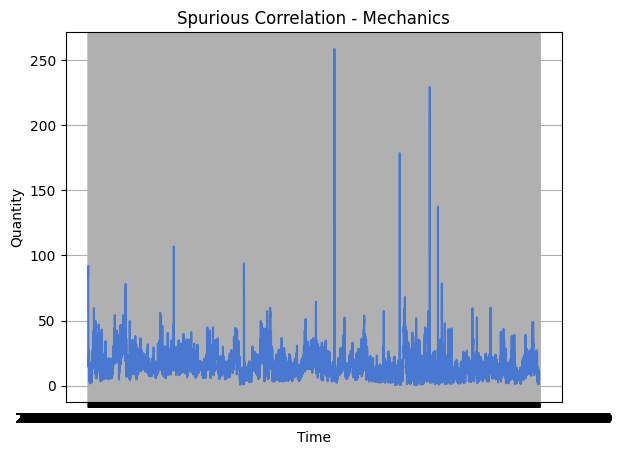

In [9]:

#Series 1

# Plotting the time series

fig, ax = plt.subplots()
ax.plot(target_data["Datum"], target_data["PM10 (Stundenmittelwerte)"], label="A")
ax.set_xlabel("Time")
ax.set_ylabel("Quantity")
ax.set_title("Spurious Correlation - Mechanics")
ax.grid()

# Components geplotted

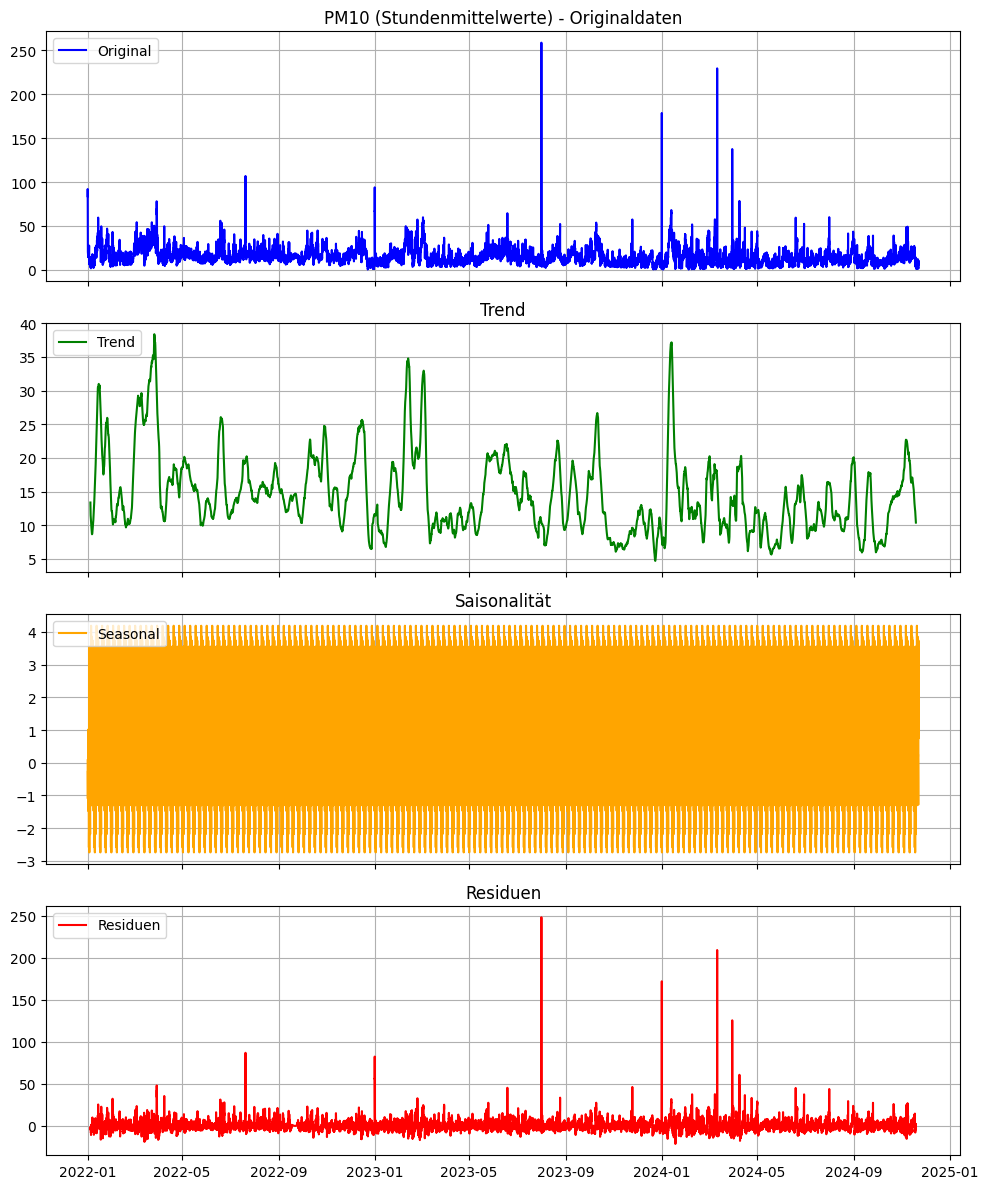

In [25]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Sicherstellen, dass der 'Datum'-Spalte ein datetime-Format hat und als Index gesetzt wird
target_data['Datum'] = pd.to_datetime(target_data['Datum'])
target_data.set_index('Datum', inplace=True)

# Saisonalität basierend auf stündlichen Daten (falls vorhanden)
# Für PM10 Mittelwerte (du kannst das für PM2.5 wiederholen)
series = target_data['PM10 (Stundenmittelwerte)']

# Frequenz (z.B. daily, hourly): Anpassung je nach Datensatz
#result = seasonal_decompose(series, model='additive', period=24)  # Für tägliche Saisonalität
result = seasonal_decompose(series, model='additive', period=168)  # 168 = 24 Stunden * 7 Tage

# Plot der Dekomposition mit Anpassungen
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Originaldaten
axes[0].plot(series, label="Original", color="blue")
axes[0].set_title("PM10 (Stundenmittelwerte) - Originaldaten")
axes[0].legend(loc="upper left")

# Trend
axes[1].plot(result.trend, label="Trend", color="green")
axes[1].set_title("Trend")
axes[1].legend(loc="upper left")

# Saisonalität
axes[2].plot(result.seasonal, label="Seasonal", color="orange")
axes[2].set_title("Saisonalität")
axes[2].legend(loc="upper left")

# Residuen
axes[3].plot(result.resid, label="Residuen", color="red")
axes[3].set_title("Residuen")
axes[3].legend(loc="upper left")

# Achsentitel und Layout
for ax in axes:
    ax.grid(True)

plt.tight_layout()
plt.show()

# Zugriff auf die Komponenten
trend = result.trend
seasonal = result.seasonal
residual = result.resid


# Dataset mit Residuals mit Seasonality weekly und daily

In [106]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Spaltennamen ausgeben
print(filtered_data.columns)

# Sicherstellen, dass die 'Datum'-Spalte ein datetime-Format hat
filtered_data['Datum'] = pd.to_datetime(filtered_data['Datum'])

# Setze die 'Datum'-Spalte als Index
filtered_data.set_index('Datum', inplace=True)

# Auswahl der Zeitreihe (PM10 Mittelwerte)
series = filtered_data['PM10 (Stundenmittelwerte)']

# 1. Wöchentliche Saisonalität entfernen
weekly_result = seasonal_decompose(series, model='multiplicative', period=168)
residuals_after_weekly = weekly_result.resid.dropna()

# 2. Tägliche Saisonalität auf den Residuen entfernen
daily_result = seasonal_decompose(residuals_after_weekly, model='multiplicative', period=24)
final_residuals = daily_result.resid.dropna()

# Neues DataFrame mit den finalen Residuen
final_residual_data = final_residuals.reset_index()
final_residual_data.columns = ['Datum', 'PM10_Final_Residual']

# Residuen-Dataset anzeigen
print(final_residual_data.head())


Index(['Datum', 'PM10 (Stundenmittelwerte)'], dtype='object')
                      Datum  PM10_Final_Residual
0 2022-01-01 00:00:00+00:00             2.861589
1 2022-01-01 01:00:00+00:00             3.080271
2 2022-01-01 02:00:00+00:00             2.291423
3 2022-01-01 03:00:00+00:00             1.700098
4 2022-01-01 04:00:00+00:00             1.437512


In [107]:
# Residual-Daten in eine CSV-Datei speichern
final_residual_data.to_csv("/Users/rubenstark/Documents/GitHub/Its-Wekk/4 - Data/Final_Data/Cleaned/final_Target_data_PM10_Residuals.csv", index=False)

print("CSV-Datei erfolgreich gespeichert.")

CSV-Datei erfolgreich gespeichert.
